## Minimum Spectral Entropy Demonstration (Phase and Delay)

This notebook demonstrates a method for controlling stochastic delay and phase noise in $H(\nu,t)e^{i(\phi_t+\epsilon_t \nu)}$, where $H(\nu,t)$ is the dynamic frequency response determined by dynamic cyclic spectroscopy, and $\phi_t$ is the unknown degenerate phase.

The method is based on minimizing the spectral entropy in $h(\tau,\omega)$

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import psrchive

def freq2time(hf, axis=0):
    return ifft(hf, axis=axis, norm="ortho")

def time2freq(ht, axis=0):
    return fft(ht, axis=axis, norm="ortho")

## Spectral Entropy

Defined as $$U = - \sum_j \sum_k p_{jk} \log_2 p_{jk},$$
where $p_{jk}$ is the fractional power spectral density,

\begin{equation}
p_{jk} = P_{jk} \Sigma_P^{-1},
\end{equation}

$P_{jk} = | h^\prime(\tau_j;\omega_k) |^2$ is the power at a
given delay and Doppler shift, and

\begin{equation}
\Sigma_P =  \sum_j \sum_k P_{jk}
\end{equation}

is the total power summed over all delays and Doppler shifts, which remains constant
as the values of $\phi_t$ and $\epsilon_t$ are varied.

See https://www.overleaf.com/read/mjqhtxmtpmmd#19ec75 for derivation of the partial derivatives $dU/d\phi_t$ and $dU/d\epsilon_t$.

In [2]:
def spectral_entropy_grad(alpha, h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform
    and freq-to-delay inverse Fourier transform of the input h_time_freq after mupltiplying each row/time (except the first) by phi
    and shifting each row/time by delay epsilon

    Args:
    alpha: A 1D array of (Ntime - 1) real-valued phase shifts, in radians,
        and (Ntime - 1) real-valued delays, in radians per cycle, to be applied to each row except the first
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy and its gradient with respect to the phase shifts
    """

    Ntime, Nchan = h_time_freq.shape
    
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))
    dh_time_freq_prime_deps_oni = np.multiply(h_time_freq_prime, nus[np.newaxis, :])

    h_time_delay_prime = ifft(h_time_freq_prime, axis=1, norm="ortho")
    dh_time_delay_prime_deps_oni = ifft(dh_time_freq_prime_deps_oni, axis=1, norm="ortho")

    phasors = np.exp(1.j * phs)
    h_time_delay_prime = np.multiply(h_time_delay_prime, phasors[:, np.newaxis])
    dh_time_delay_prime_deps_oni = np.multiply(dh_time_delay_prime_deps_oni, phasors[:, np.newaxis])
    
    h_doppler_delay_prime = fft(h_time_delay_prime, axis=0, norm="ortho")
    
    power_spectrum = np.abs(h_doppler_delay_prime)**2
    
    total_power = np.sum(power_spectrum)
    power_spectrum /= total_power
    log_power_spectrum = np.log2(power_spectrum + 1e-16)
    entropy = -np.sum(power_spectrum * log_power_spectrum)

    weighted_ifft = ifft((1.+log_power_spectrum)*h_doppler_delay_prime, axis=0, norm="ortho")

    # partial derivatives with respect to phi_l
    gradient_phs = 2.0/total_power * np.sum( np.imag( np.conj(weighted_ifft)*h_time_delay_prime ), axis=1)
    grad_phs_power = np.sum(gradient_phs**2)

    # partial derivatives with respect to epsilon_l
    gradient_eps = 2.0/total_power * np.sum( np.imag( np.conj(weighted_ifft)*dh_time_delay_prime_deps_oni ), axis=1)    
    grad_eps_power = np.sum(gradient_eps**2)

    rms = np.sqrt(np.sum(phs**2) / (Ntime-1))
    print (f"rms={rms:.4g} rad; S={entropy} grad power phs={grad_phs_power:.4} eps={grad_eps_power:.4}")

    return entropy, np.concatenate((gradient_phs[1:],gradient_eps[1:]))

def spectral_entropy(h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform 
    of the input h_time_delay

    Args:
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy
    """
    nsub, nchan = h_time_freq.shape
    alpha = np.zeros(2*(nsub-1))
    entropy, grad = spectral_entropy_grad(alpha,h_time_freq)
    return entropy

## Simulated scattering screen

Load a simulated dynamic response, $H(\nu,t)$ that was generated using 

    dyn_resp_sim input.ar -w 5 -r 0.10
    
This generates a single scintillation arc with a Gaussian width of 5 pixels.  The following code also plots $h(\tau,\omega)$ and reports the original entropy.

In [3]:
import psrchive

filename = "test/dyn_resp_sim.fits"
ar = psrchive.Archive.load(filename)
ext = ar.get_dynamic_response()
data = ext.get_data()
nchan = ext.get_nchan()
ntime = ext.get_ntime()
h_time_freq = np.reshape(data, (ntime, nchan))

rms=0 rad; S=10.595536947345163 grad power phs=0.0002378 eps=2.256e-05
Spectral Entropy: 10.595536947345163
Total Power: 300780.232324424


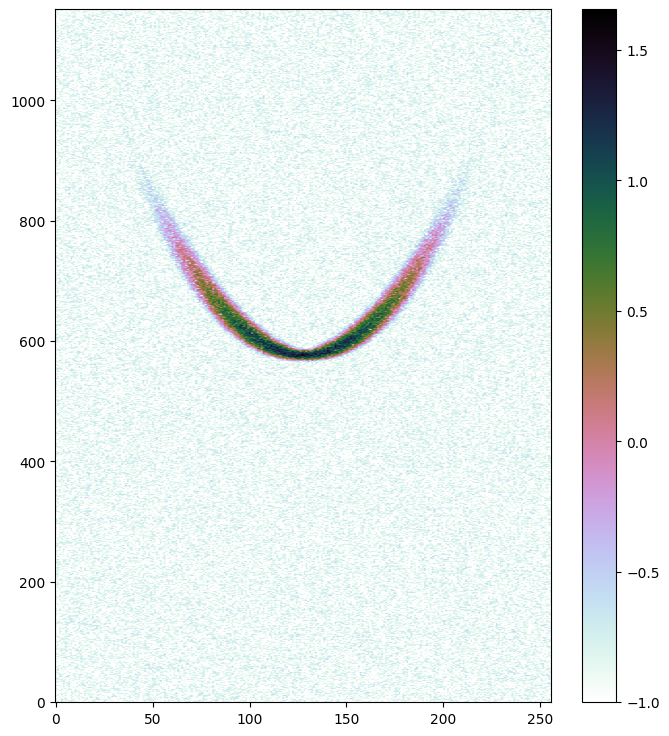

In [4]:
def plot (h_time_freq):
    h_time_delay = freq2time(h_time_freq, axis=1)
    print(f"Spectral Entropy: {spectral_entropy(h_time_freq)}")
    h_doppler_delay = time2freq(h_time_delay, axis=0)
    power = np.sum(np.abs(h_doppler_delay)**2)
    print(f"Total Power: {power}")
    plotthis = np.log10(np.abs(fftshift(h_doppler_delay)) + 1e-2)
    fig, ax = plt.subplots(figsize=(8, 9))
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=-1)
    fig.colorbar(img)
    
plot(h_time_freq)

## Scramble the delays

Multiply each row of the dynamic frequency response by a random phase gradient.

**Note how the spectral entropy is increased from 10.6 to 11.9.**

rms=0 rad; S=12.059461972599472 grad power phs=0.0007868 eps=0.003548
Spectral Entropy: 12.059461972599472
Total Power: 300780.232324424


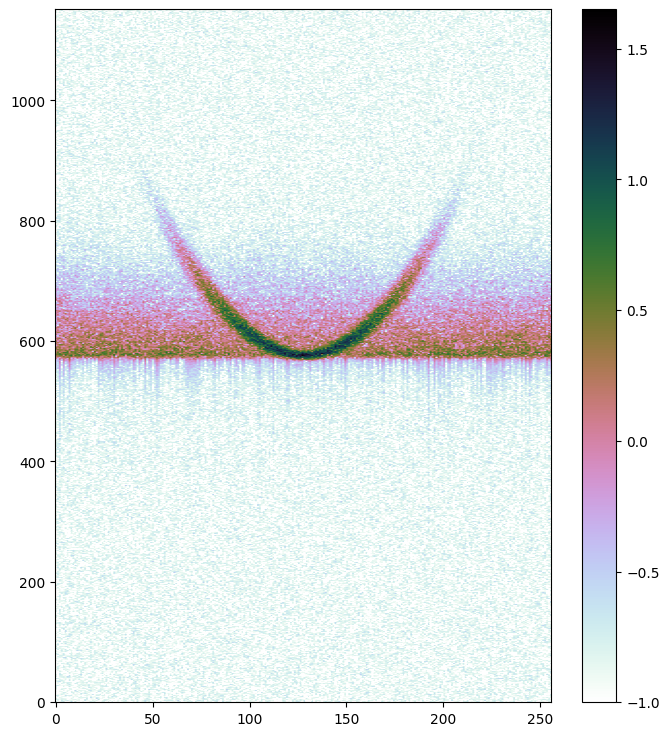

In [5]:
eps = np.random.uniform(-np.pi,np.pi,ntime)
nus = np.fft.fftfreq(nchan)
h_time_freq = h_time_freq * np.exp(1j * np.outer(eps, nus))
plot(h_time_freq)

## Minimize the spectral entropy

Multiply each row of the scrambled dynamic frequency response by a phase that minimizes the spectral entropy

**Note how the spectral entropy decreases to 10.56, which is slightly lower than the original entropy, but there are still residual artefacts.**

In [6]:
from scipy.optimize import minimize

def circular(x):
    x[:] = np.fmod(x, 2.0*np.pi)

def minimize_spectral_entropy(h_time_freq):

    Ntime, Nchan = h_time_freq.shape
    initial_guess = np.zeros(2*(Ntime - 1))

    options = {"maxiter": 1000, "disp": True}

    result = minimize(
        spectral_entropy_grad,
        initial_guess,
        args=(h_time_freq,),
        method="BFGS",
        jac=True,
        callback=circular,
        options=options,
    )

    alpha = result.x
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))

    phasors = np.exp(1.j * phs)
    h_time_freq[:,:] = np.multiply(h_time_freq_prime, phasors[:, np.newaxis])
    
minimize_spectral_entropy(h_time_freq)

rms=0 rad; S=12.059461972599472 grad power phs=0.0007868 eps=0.003548
rms=0.001756 rad; S=12.055134987321312 grad power phs=0.0007522 eps=0.003556
rms=0.00878 rad; S=12.037966387955288 grad power phs=0.0006204 eps=0.003586
rms=0.03688 rad; S=11.971766044496416 grad power phs=0.0002202 eps=0.003679
rms=0.1493 rad; S=11.761913927456854 grad power phs=0.002074 eps=0.003557
rms=0.3384 rad; S=11.687737867849743 grad power phs=0.02211 eps=0.001929
rms=0.2725 rad; S=11.648427617026762 grad power phs=0.01338 eps=0.002569
rms=0.2513 rad; S=11.625467912577665 grad power phs=0.01103 eps=0.002748
rms=0.2277 rad; S=11.581390747127989 grad power phs=0.00869 eps=0.00292
rms=0.196 rad; S=11.496924415159736 grad power phs=0.005797 eps=0.00311
rms=0.1549 rad; S=11.340095406060243 grad power phs=0.002362 eps=0.003244
rms=0.1396 rad; S=11.085704790571382 grad power phs=0.002879 eps=0.00275
rms=0.2234 rad; S=10.920825186391296 grad power phs=0.02157 eps=0.0007539
rms=0.205 rad; S=10.844643636407204 grad po

rms=0 rad; S=10.559042175014488 grad power phs=8.859e-10 eps=8.148e-06
Spectral Entropy: 10.559042175014488
Total Power: 300780.2323244241


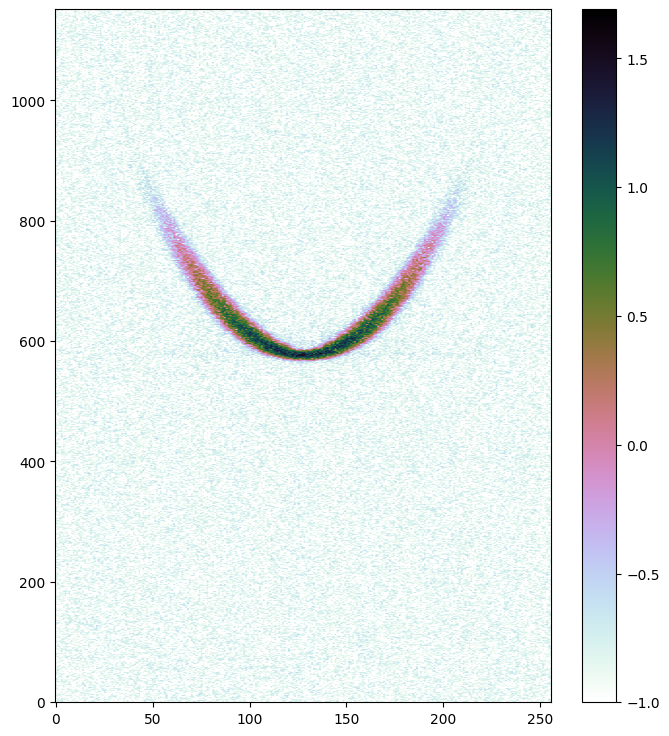

In [7]:
plot(h_time_freq)

## Astrophysical scattering screen

In [8]:
import pickle
with open ("reproduce_0/filters_full_0.pkl", "rb") as fh:
    h_time_freq = pickle.load(fh)

ntime, nchan = h_time_freq.shape

rms=0 rad; S=13.664134615626729 grad power phs=2.944e-05 eps=5.821e-06
Spectral Entropy: 13.664134615626729
Total Power: 1916927.9999999993


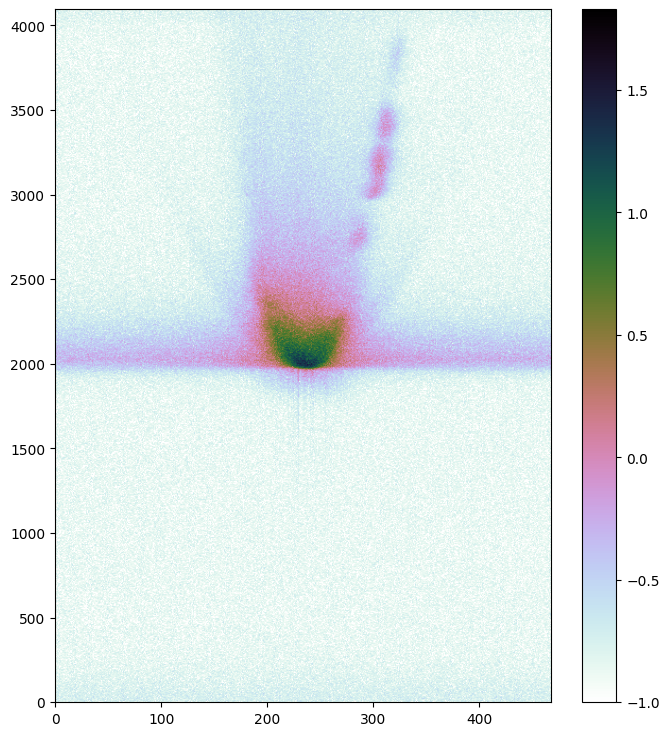

In [9]:
plot(h_time_freq)

In [10]:
minimize_spectral_entropy(h_time_freq)

rms=0 rad; S=13.664134615626729 grad power phs=2.944e-05 eps=5.821e-06
rms=0.000251 rad; S=13.664099573477156 grad power phs=2.886e-05 eps=5.804e-06
rms=0.001255 rad; S=13.663962429476838 grad power phs=2.663e-05 eps=5.74e-06
rms=0.005271 rad; S=13.663462270793339 grad power phs=1.933e-05 eps=5.488e-06
rms=0.01705 rad; S=13.662432175356301 grad power phs=1.271e-05 eps=4.796e-06
rms=0.02984 rad; S=13.662023824158071 grad power phs=2.906e-05 eps=4.127e-06
rms=0.0306 rad; S=13.661989070077324 grad power phs=2.963e-05 eps=4.079e-06
rms=0.03367 rad; S=13.661868052581596 grad power phs=3.23e-05 eps=3.894e-06
rms=0.038 rad; S=13.661582464686377 grad power phs=3.136e-05 eps=3.609e-06
rms=0.04447 rad; S=13.661088050062745 grad power phs=2.706e-05 eps=3.2e-06
rms=0.05616 rad; S=13.66044124889071 grad power phs=3.294e-05 eps=2.625e-06
rms=0.05933 rad; S=13.660293540445128 grad power phs=4.306e-05 eps=2.492e-06
rms=0.05924 rad; S=13.660209710095467 grad power phs=4.701e-05 eps=2.473e-06
rms=0.0584

rms=0 rad; S=13.605753259876534 grad power phs=4.432e-09 eps=5.045e-07
Spectral Entropy: 13.605753259876534
Total Power: 1916927.9999999998


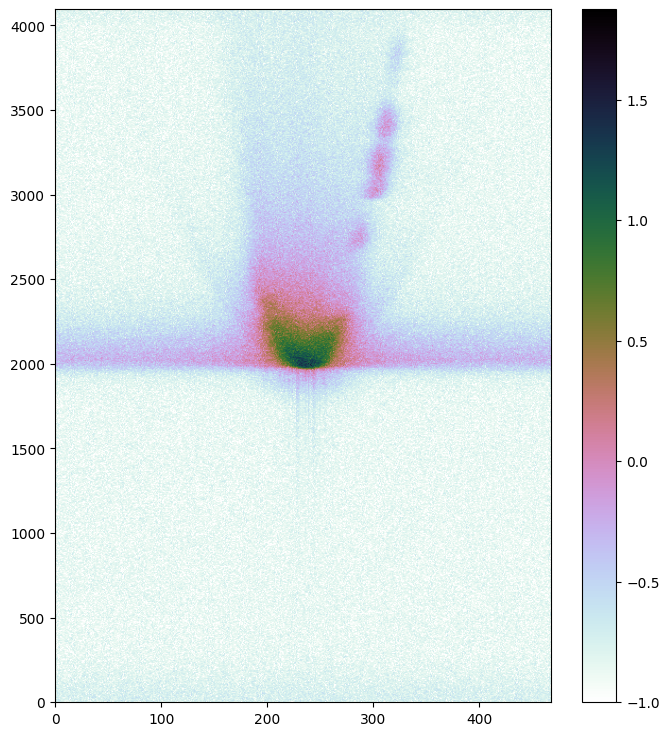

In [11]:
plot(h_time_freq)